# No YOU hang up!
### How to get our customers to stay on the line

[![Click for Fun](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.ulVpKZ_MlUS1R20VPrQZ3QHaEK%26pid%3DApi&f=1)](https://www.youtube.com/watch?v=5sIFYkMEtlk)


In [66]:
# imports
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# import sklearn helper functions
import sklearn.feature_selection as feat_select
from sklearn.preprocessing import LabelEncoder, normalize # <-- double check to see if you need this one

# import models
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# set seaborn defaults
sns.set_palette('plasma')
sns.set_context("talk")

# import custom modules
import acquire
import prepare
from explore import plot_counts, contingency_metrics, run_metrics

#ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

# Project Intro - Setting the Scene
- In previous [project](https://public.tableau.com/app/profile/heather.mcmillan/viz/StorytellingProject-TelcoChurn/RetentionPresentation) found that 50% of month to month customers who churn, do so in the first 7 months
- I mentioned that with further analysis I would like to take a closer look at this problem of early churn

## The Burning Question
### <font color=purple>**What makes customers leave within first year, and can we predict that?**</font>

# Executive Summary - Conclusions & Next Steps
- My Model 4 (a Random Forest) performed best, using most of the features in our dataset
    - Accuracy on validate was 91.7%
    - Recall was 67%
    - Accuracy on Test 89.3% accuracy which was only slighly lower than our accuracy on validate set
    - Recall stayed pretty high (relatively so) as well 64.9%
- Dive down into feature selection and engineering to see if this can bump up model performance
- Splitting up the data further and running tests on only the Month to Month customers
- Split up data to hide tenure, and only do customers who've been with the company for a year

### How did I prepare?
- trello board
- gather deliverables
- read rubric 6 times

### Plan for today
- How? 
    - exploration, testing, and modeling
- What I discovered? 
     - Evidence to suggest *Payment type* and *having internet service* have a relationship with churning in the first year


<hr style="border-top: 10px groove #5302a3; margin-top: 1px; margin-bottom: 1px"></hr>

# Acquire

In [2]:
# use acquire function to obtain dataframe
df = acquire.get_telco_data()

In [58]:
df.shape

(7043, 24)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   churn                     7043 non-null   object 
 2   gender                    7043 non-null   object 
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   object 
 5   dependents                7043 non-null   object 
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   object 
 8   multiple_lines            7043 non-null   object 
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

### What I needed to change
<img src="images/screenshot1.png" alt="columns" width="500"/>


In [4]:
# When exploring this set before I knew there were empty values in the total_charges column
# This column type is object, there are 11 'blanks', those blanks turned out to be spaces
# Added a str.replace aspect to my prepare module
df.total_charges.value_counts()

           11
20.2       11
19.75       9
19.65       8
20.05       8
           ..
746.05      1
3965.05     1
914         1
4303.65     1
5289.05     1
Name: total_charges, Length: 6531, dtype: int64

In [5]:
# this went into my prepare function, replace the space with the string 0 then change to a float
df.total_charges = df.total_charges.str.replace(' ', '0').astype(float)


<hr style="border-top: 10px groove #8b0aa5; margin-top: 1px; margin-bottom: 1px"></hr>


# Prepare

## Cleaning checklist 
(26 columns to start)
- [x] drop duplicate columns (done in SQL) (23 columns now)

create two seperate prepares **prepare_explore** and **prepare_model**

- will leave in Yes's and No's for readability in explore section

<font color='#b83289'> **prepare_explore** </font>

- [x] find and deal with empty values (11 empty ones in total_charges)
- [x] change money columns to floats
- [x] split train test

<font color='#febd2a'>  **prepare_model**  </font> 
- [x] change all yes's and no's to 0s and 1s
- [x] change all obejcts to numbers (except where nessicary)
- [x] drop all '_id' columns


- [x] create new feature, *'less_than_a_year'* from tenure and churn

#### Things I was looking for: what the overall snapshot of the data, who are the customers in this dataset?

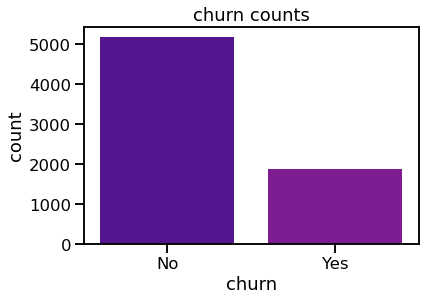

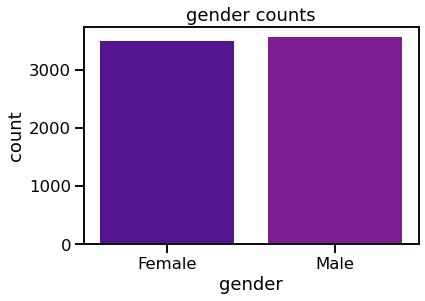

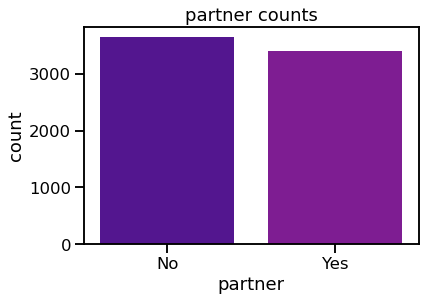

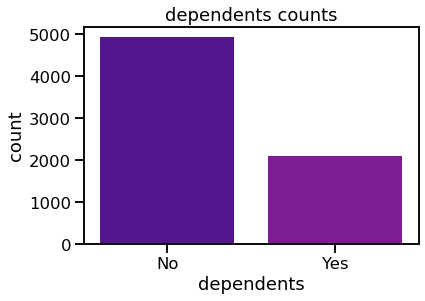

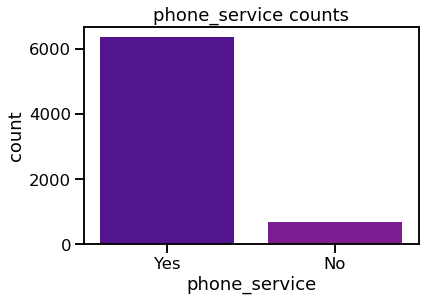

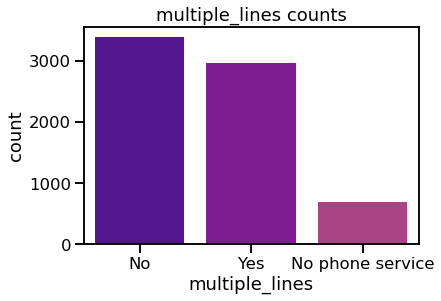

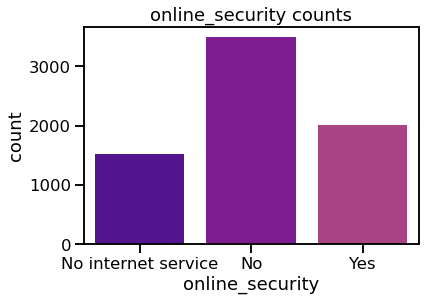

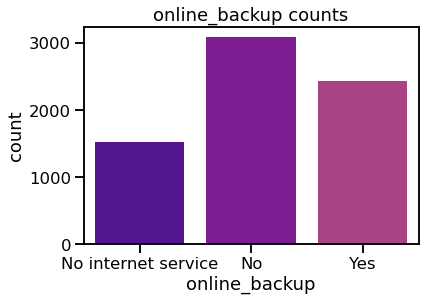

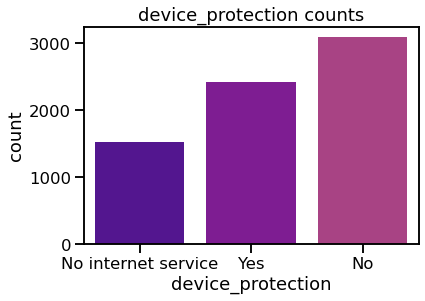

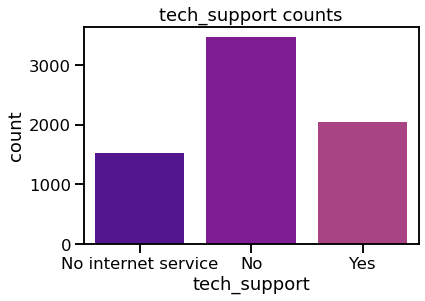

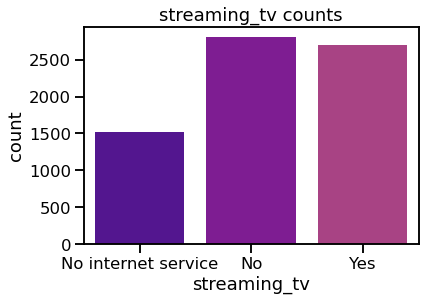

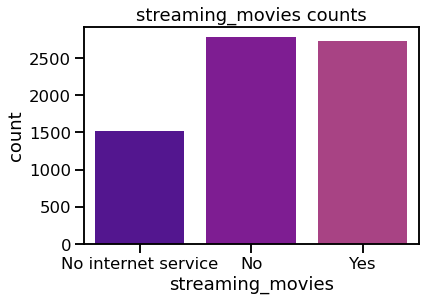

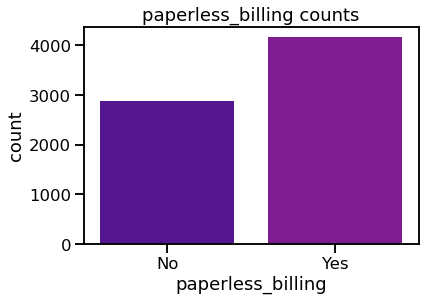

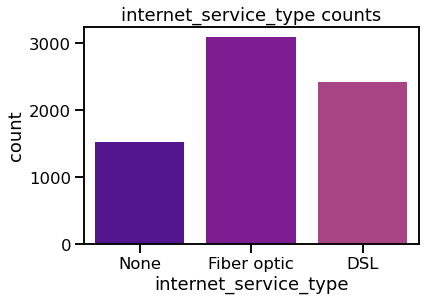

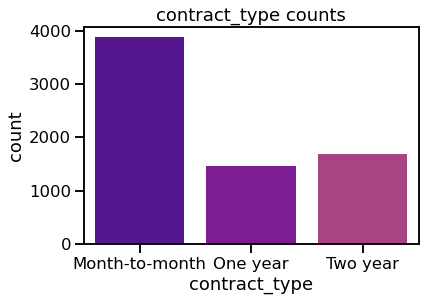

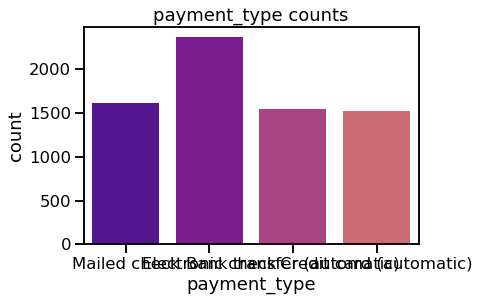

In [67]:
# use function from acquire for plotting counts
plot_counts(df)

### Takeaways from Bar plots
- Not a lot of customers don't have phone service
- A lot of customers in this data *don't churn*

## Do I have enough data points to answer the question?
- I am looking for enough people who churned in the first 12 months
- I know from previous project half of month to month customers leave within the first year, so I'm confident I'll have enough data to work with

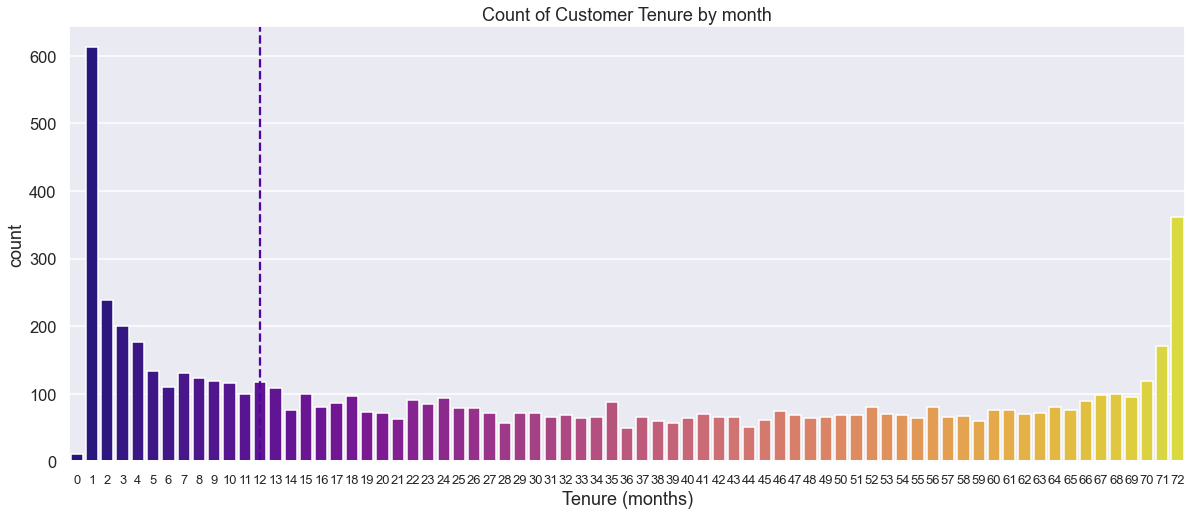

In [7]:
# plot the counts of customer tenure by month, purple line is 1 year
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20,8))
    sns.countplot(df.tenure, palette=('plasma'))
    plt.title('Count of Customer Tenure by month')
    plt.xlabel('Tenure (months)')
    plt.xticks(fontsize = 13)
    plt.axvline(x=12, linestyle= '--')
    plt.show()

In [8]:
# I tried to see if there was enough data for me to look at only the people who churned in the first year
print(df.churn.value_counts()), 
print(f'\nTotal datapoints: {df.churn.count()}')

No     5174
Yes    1869
Name: churn, dtype: int64

Total datapoints: 7043


In [9]:
# it seemed there was a sizeable amount of customers who had tenure less than a year
print(df[df.tenure < 12].churn.value_counts())
print(f'\n Total Datapoints with tenure < 12 months: {df[df.tenure < 12].churn.count()}')

No     1070
Yes     999
Name: churn, dtype: int64

 Total Datapoints with tenure < 12 months: 2069


### It looks like I'll have enough data to move on. Here is where. I decided to make a new column for the next phase

<hr style="border-top: 10px groove #b83289; margin-top: 1px; margin-bottom: 1px"></hr>

# Explore 

In [10]:
# use function from prepare to get ready to explore
train, validate, test = prepare.prep_telco(acquire.get_telco_data())

In [11]:
# Change senior_citizen to astype string for exploration. The 0s and 1s were not helpful yet
train.senior_citizen = train.senior_citizen.astype(str)

In [12]:
# split columns into two sections discrete and continous variables
cols_discrete = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'internet_service_type',
 'contract_type',
 'payment_type']

cols_for_box = ['internet_service_type', 'payment_type', 'paperless_billing']

cols_continuous = [ 'monthly_charges',
         'tenure', 'total_charges']

## Continuous Plots

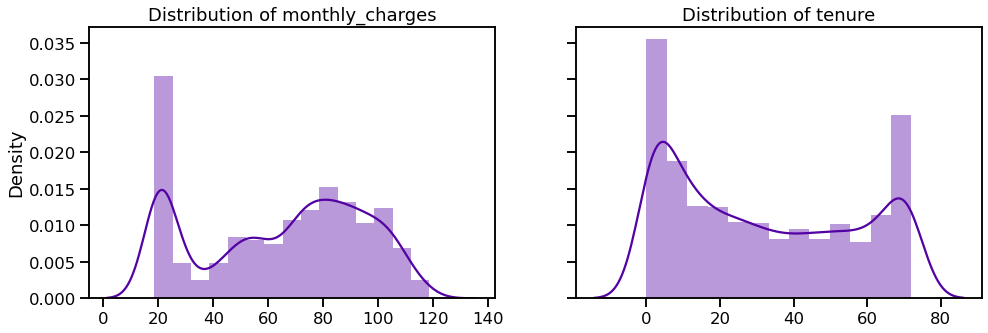

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16,5), sharey=True)
for ax, var in zip(axs, cols_continuous):
    sns.distplot(x = train[var], ax = ax)
    ax.set(title=f'Distribution of {var}')

## Categorical Plots

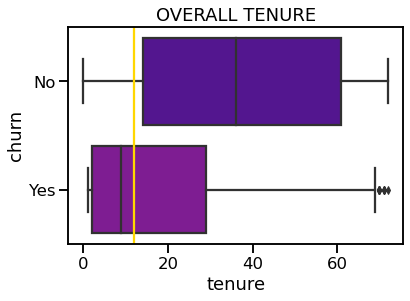

In [14]:
# this is the entire demographic! 
# compare this to all the variables to see a difference
sns.boxplot(x = train.tenure, y = train.churn)
# plot horizontal line at the 12 month mark
plt.axvline(x = 12, c='gold')
plt.title('OVERALL TENURE')
plt.show()

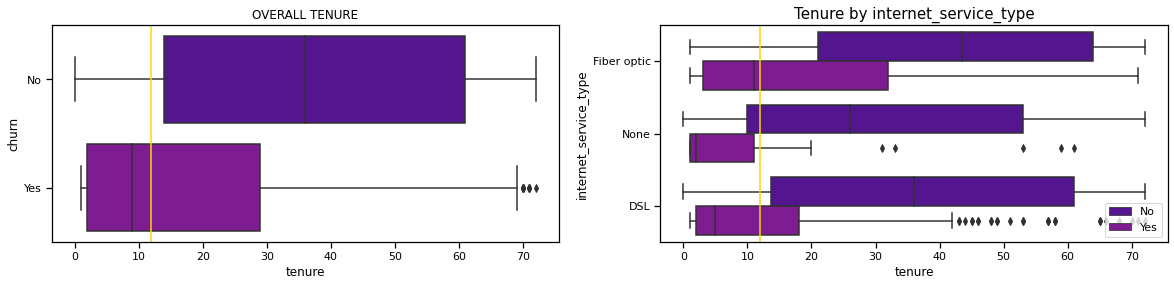

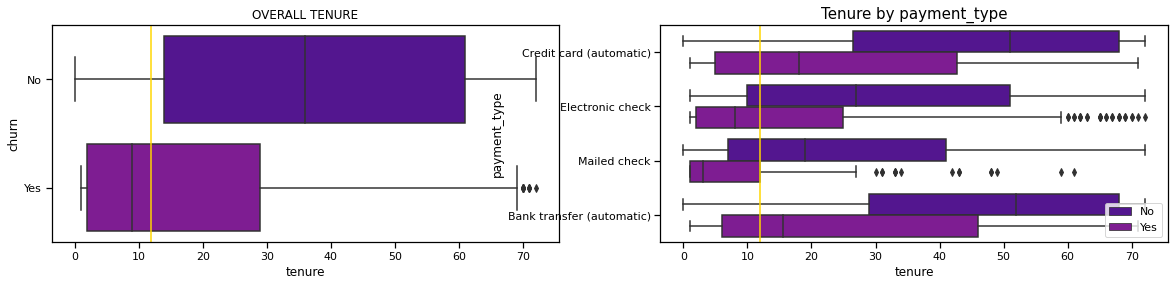

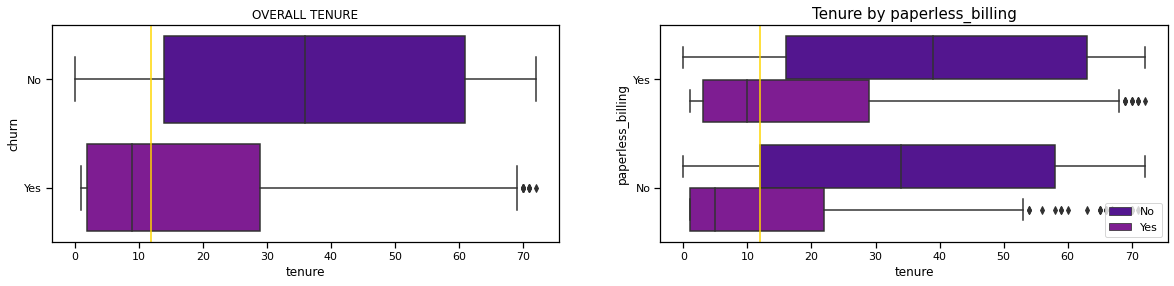

In [15]:
sns.set_context('notebook')

# to see ALL discrete variables replace 'cols_for_box' with 'cols_discrete'

for col in cols_for_box:
    plt.figure(figsize = (20,4))
    plt.subplot(121)
    sns.boxplot(x = train.tenure, y = train.churn)
    plt.title('OVERALL TENURE')
    # gold line is for looking at customers with tenure less than a year
    plt.axvline(x = 12, c='gold')
    
    plt.subplot(122)
    sns.boxplot(x = train.tenure, y = train[col], hue = train.churn)
    plt.legend(loc= 'lower right')
    plt.title(f'Tenure by {col}', fontsize = 15)
    plt.axvline(x = 12, c='gold')

## Takeaways from box plots
- *Not having internet*, and *paying by a mailed check*, big chunk of those customers (lower 3 quartiles) churn before 1 year
- Less significant but still big chunk of people, people who *have dsl* and *aren't in paperless billing*
- Seems like less services they have, more likely they are to churn

-----

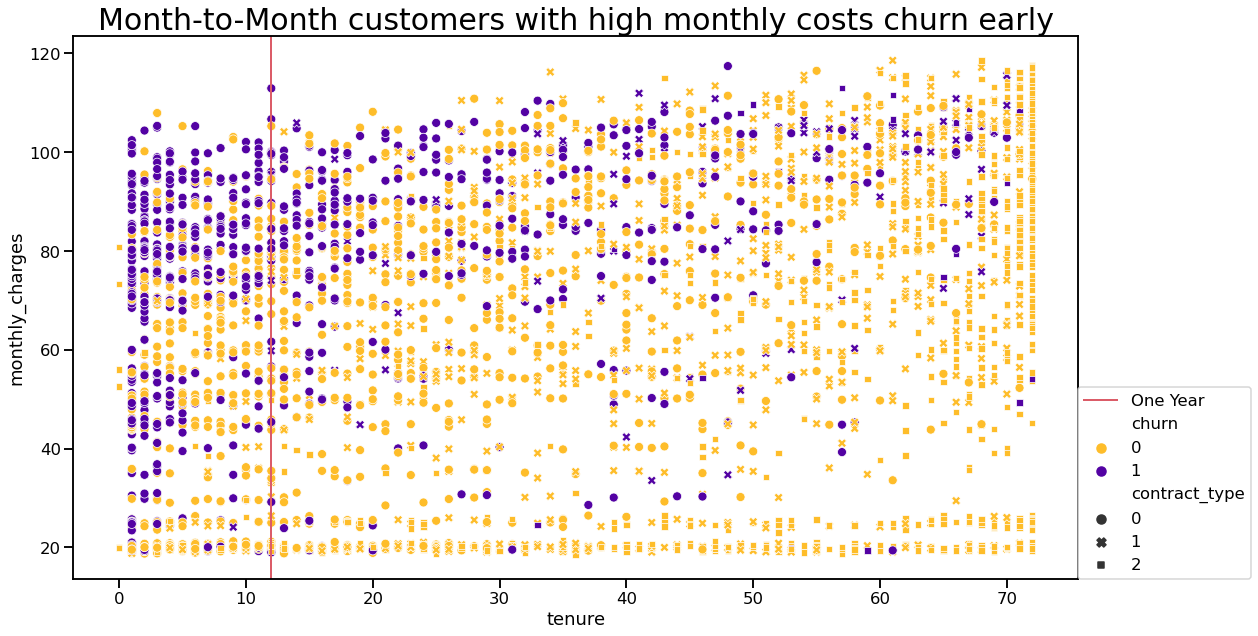

In [62]:
# set colors for markers
colors = ['#febd2a', '#5302a3']

sns.set_context("talk")

plt.figure(figsize = (18,10))
sns.scatterplot(x = train.tenure, y = train.monthly_charges, hue=train.churn, palette=(colors), style = train.contract_type)
plt.axvline(x = 12, c = '#db5c68', linewidth = 2, label = 'One Year')
plt.title('Month-to-Month customers with high monthly costs churn early', fontsize = 30)
# moves legend to outside on the bottom
plt.legend(loc = (1,0))
plt.show()

## Takeaway from Scatter Plot
- Like I learned from my other project, month to month customers churn before 12 months and have high monthly costs

# Chosing my target
- Instead of looking for just churn I will be looking at customers who churn within the first 12 months
- this line of code is in my prepare file

```python

df['less_than_a_year'] = (((df['tenure'] < 12) == True) & ((df['churn'] == 1) == True)).astype(int)

```
- Target Column: **less_than_a_year**

<div class="alert alert-block alert-info"><b>KEEP IN MIND:</b> There are a lot less people in this category than just general churn, so the negative (not churning in the first 12 months) is much easier to guess.</div>

<hr style="border-top: 10px groove #db5c68; margin-top: 1px; margin-bottom: 1px"></hr>

# Hypothesis
### Does having Internet relate to whether customer churns in the first year?
$H_0$ : Internet service type independent from churn in first year

$H_a$: Internet service type not independent from churn in first year

alpha = 0.05

### Does paying by a mailed check relate to whether customer churns in the first year?
$H_0$: Paying by a mailed check (payment type) is independent to whether or not a person churns within the first year

$H_a$: Paying by a mailed check (payment type) is not independent from churn in first year

alpha = 0.05


In [17]:
# import explore data but with target included
train, validate, test = prepare.prep_telco_hypothesis(acquire.get_telco_data())

In [18]:
# A glance at our new target: less_than_a_year
train[['churn', 'tenure', 'less_than_a_year']].head(6)

,churn,tenure,less_than_a_year
1148,No,9,0
1162,Yes,32,0
679,No,21,0
209,No,1,0
6827,No,62,0
2779,Yes,7,1


In [19]:
# create crosstab for hypothesis 1 internet service type independent from churn under a year
crosstab1 = pd.crosstab(train.less_than_a_year, train.internet_service_type)

In [20]:
contingency_metrics(crosstab1)

~~ Observed ~~



internet_service_type,DSL,Fiber optic,None
less_than_a_year,,,
Stayed,1201,1371,797
Churned,160,373,41



~~ Expected ~~



internet_service_type,DSL,Fiber optic,None
less_than_a_year,,,
Stayed,1163.0,1490.0,716.0
Churned,198.0,254.0,122.0



~~ Statistics ~~

chi^2 = 136.9304
p     = 0.0000

~~~~ We can reject the null hypothesis. Yay! ~~~~


In [21]:
# create crosstab for hypothesis 2 payment type independant from churn under a year
crosstab2 = pd.crosstab(train.less_than_a_year, train.internet_service_type)

In [22]:
contingency_metrics(crosstab2)

~~ Observed ~~



internet_service_type,DSL,Fiber optic,None
less_than_a_year,,,
Stayed,1201,1371,797
Churned,160,373,41



~~ Expected ~~



internet_service_type,DSL,Fiber optic,None
less_than_a_year,,,
Stayed,1163.0,1490.0,716.0
Churned,198.0,254.0,122.0



~~ Statistics ~~

chi^2 = 136.9304
p     = 0.0000

~~~~ We can reject the null hypothesis. Yay! ~~~~


### Hypothesis Takeaways
$H_0$ : internet service type independent from churn in first year <font color=blue>CAN REJECT</font>

$H_a$: internet service type not independent from churn in first year <font color=green>Evidence to suggest alternate hypothesis</font> 

alpha = 0.05

$H_0$: Paying by a mailed check (payment type) is independent to whether or not a person churns within the first year <font color=blue>CAN REJECT</font>

$H_a$: Paying by a mailed check (payment type) is not independent from churn in first year <font color=green>Evidence to suggest alternate hypothesis</font>

alpha = 0.05

<hr style="border-top: 10px groove #febd2a; margin-top: 1px; margin-bottom: 1px"></hr>

# Modeling

###  Where to start? Establish a Baseline Accuracy
- Baseline to be created is the most common (which will be no one churns!)

### Takeaways baseline - Baseline is predicting no one churns
- Baseline accuracy for all churn is 73% 
- Baseline accuracy for all predicting people leaving in less than a year is **85%** and this is what we'll be using

In [23]:
# Import data again with function that turns strings to 0s, 1s and 2s
train, validate, test = prepare.prep_telco_model(acquire.get_telco_data())

In [24]:
# add column that is the baselone 0 = not churned
train['baseline'] = 0
baseline = train.baseline

In [25]:
baseline_accuracy = (train.less_than_a_year == train.baseline).mean()
print(f'The baseline accuracy is {baseline_accuracy: .0%}')

The baseline accuracy is  85%


## LOOK FOR: Accuracy higher than 85% and a higher Recall
- Worst case is missing someone who will churn (False Negative), so optimization for recall 


<hr style="border-top: 10px groove #febd2a; margin-top: 1px; margin-bottom: 1px"></hr>

## Model 1 Decision Tree
- Hyper Parameters: max leaf nodes = 10
- Recall rate 65%
- Precision rate of 91.8%

In [26]:
#decide on features to put into model
X_cols = ['gender', 'senior_citizen','partner','dependents','tenure','phone_service','multiple_lines','online_security',
          'online_backup','device_protection','tech_support','streaming_tv','streaming_movies','paperless_billing','monthly_charges',
          'total_charges','internet_service_type','contract_type','payment_type']

#target
y_col = 'less_than_a_year'

In [27]:
# create X/ys
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [28]:
# create model 1
model1 = DecisionTreeClassifier(max_leaf_nodes= 10)

# fit to train dataset
model1.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=10)

In [29]:
run_metrics(X_train, y_train, model1, data_set='Train')

Train data set accuracy score: 91.83%
Train data set recall score: 73.87%
Train data set precision score 71.14%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3369
           1       0.71      0.74      0.72       574

    accuracy                           0.92      3943
   macro avg       0.83      0.84      0.84      3943
weighted avg       0.92      0.92      0.92      3943

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 3197,False positive: 172
actual_churned,False Negative: 150,True Positive: 424


 
Train data set model metrics
---------------------------------
True positive rate for the model is 73.87%
False positive rate for the model is  5.11%
True negative rate for the model is 94.89%
False negative rate for the model is 26.13%
-------------------------------


In [30]:
run_metrics(X_validate, y_validate, model1, data_set='Validate')

Validate data set accuracy score: 90.72%
Validate data set recall score: 65.00%
Validate data set precision score 64.13%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1471
           1       0.64      0.65      0.65       220

    accuracy                           0.91      1691
   macro avg       0.79      0.80      0.80      1691
weighted avg       0.91      0.91      0.91      1691

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1391,False positive: 80
actual_churned,False Negative: 77,True Positive: 143


 
Validate data set model metrics
---------------------------------
True positive rate for the model is 65.00%
False positive rate for the model is  5.44%
True negative rate for the model is 94.56%
False negative rate for the model is 35.00%
-------------------------------


### Takeaways Model 1
- Model 1 performed very well with a 90.7% accuracy rate
- Predicting someone will churn is what we're aiming for
- this model has a fair recall 65% (a little over fit in the recall deparment to the train model)
- very high precision though, 95%, aka good at predicting someone will stay, not hard though since a lot of people do

<hr style="border-top: 10px groove #febd2a; margin-top: 1px; margin-bottom: 1px"></hr>

## Model 2 - KNN
- Type KNN
- using only categorical variables (i.e. no monthly or total charges, or tenure)
- Accuracy 84%
- Recall 28%

In [31]:
#decide on features to put into model
X_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [32]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [33]:
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(X_train, y_train)

KNeighborsClassifier()

In [34]:
run_metrics(X_train, y_train, model2, data_set='Train')

Train data set accuracy score: 88.51%
Train data set recall score: 45.30%
Train data set precision score 65.16%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3369
           1       0.65      0.45      0.53       574

    accuracy                           0.89      3943
   macro avg       0.78      0.71      0.73      3943
weighted avg       0.87      0.89      0.88      3943

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 3230,False positive: 139
actual_churned,False Negative: 314,True Positive: 260


 
Train data set model metrics
---------------------------------
True positive rate for the model is 45.30%
False positive rate for the model is  4.13%
True negative rate for the model is 95.87%
False negative rate for the model is 54.70%
-------------------------------


In [35]:
run_metrics(X_validate, y_validate, model2, data_set="Validate")

Validate data set accuracy score: 84.74%
Validate data set recall score: 28.18%
Validate data set precision score 38.27%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1471
           1       0.38      0.28      0.32       220

    accuracy                           0.85      1691
   macro avg       0.64      0.61      0.62      1691
weighted avg       0.83      0.85      0.84      1691

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1371,False positive: 100
actual_churned,False Negative: 158,True Positive: 62


 
Validate data set model metrics
---------------------------------
True positive rate for the model is 28.18%
False positive rate for the model is  6.80%
True negative rate for the model is 93.20%
False negative rate for the model is 71.82%
-------------------------------


### Takeaways Model 2
- this model did not perform better than model 2
- it did well at guessing people who stayed but did very bad guessing people who churned
- the True Positive rate was 28%!!! Bad at guessing churn which is what we need
- recall is BAD

<hr style="border-top: 10px groove #febd2a; margin-top: 1px; margin-bottom: 1px"></hr>

## Model 3 - Random Forest 
- Type: Random forest 
- Variables, top ones that I chose with statistical testing 
- Will probably make a model 4 with all the columns
- Accuracy:  90.6%
- recall : 62.27%

In [68]:
#decide on features to put into model
X_cols = [
 'senior_citizen',
 'phone_service',
 'tenure',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [37]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [38]:
# make model and fit to train
model3 = RandomForestClassifier()
model3.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
run_metrics(X_train, y_train, model3, data_set="Train")

Train data set accuracy score: 93.15%
Train data set recall score: 78.57%
Train data set precision score 75.42%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3369
           1       0.75      0.79      0.77       574

    accuracy                           0.93      3943
   macro avg       0.86      0.87      0.86      3943
weighted avg       0.93      0.93      0.93      3943

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 3222,False positive: 147
actual_churned,False Negative: 123,True Positive: 451


 
Train data set model metrics
---------------------------------
True positive rate for the model is 78.57%
False positive rate for the model is  4.36%
True negative rate for the model is 95.64%
False negative rate for the model is 21.43%
-------------------------------


In [40]:
run_metrics(X_validate, y_validate, model3, data_set='Validate')

Validate data set accuracy score: 90.66%
Validate data set recall score: 62.27%
Validate data set precision score 64.62%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1471
           1       0.65      0.62      0.63       220

    accuracy                           0.91      1691
   macro avg       0.80      0.79      0.79      1691
weighted avg       0.91      0.91      0.91      1691

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1396,False positive: 75
actual_churned,False Negative: 83,True Positive: 137


 
Validate data set model metrics
---------------------------------
True positive rate for the model is 62.27%
False positive rate for the model is  5.10%
True negative rate for the model is 94.90%
False negative rate for the model is 37.73%
-------------------------------


### Takeaways Model 3
- Model 3 did slightly (and I mean *slightly* better) than model 1
- It has a 90.8% accuracy on the validate set 
- A false negative rate of 36.36
- Recall is 63% which is slightly lower than model 1
- So far this is the winner

<hr style="border-top: 10px groove #febd2a; margin-top: 1px; margin-bottom: 1px"></hr>

## Model 4 - Random Forest
- Type: random forest
- Variables: add of the categorical and add continuous ones 
- Accuracy: 91.7%
- Recall: 67%

In [41]:
#decide on features to put into model
X_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [42]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [43]:
# make model and fit to train
model4 = RandomForestClassifier(random_state = 713)
model4.fit(X_train, y_train)

RandomForestClassifier(random_state=713)

In [44]:
run_metrics(X_train, y_train, model4, data_set="Train")

Train data set accuracy score: 99.87%
Train data set recall score: 99.65%
Train data set precision score 99.48%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3369
           1       0.99      1.00      1.00       574

    accuracy                           1.00      3943
   macro avg       1.00      1.00      1.00      3943
weighted avg       1.00      1.00      1.00      3943

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 3366,False positive: 3
actual_churned,False Negative: 2,True Positive: 572


 
Train data set model metrics
---------------------------------
True positive rate for the model is 99.65%
False positive rate for the model is  0.09%
True negative rate for the model is 99.91%
False negative rate for the model is 0.35%
-------------------------------


In [45]:
run_metrics(X_validate, y_validate, model4, data_set='Validate')

Validate data set accuracy score: 91.72%
Validate data set recall score: 67.27%
Validate data set precision score 68.52%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1471
           1       0.69      0.67      0.68       220

    accuracy                           0.92      1691
   macro avg       0.82      0.81      0.82      1691
weighted avg       0.92      0.92      0.92      1691

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1403,False positive: 68
actual_churned,False Negative: 72,True Positive: 148


 
Validate data set model metrics
---------------------------------
True positive rate for the model is 67.27%
False positive rate for the model is  4.62%
True negative rate for the model is 95.38%
False negative rate for the model is 32.73%
-------------------------------


### Takeaways Model 4
- Model 4 did suprisingly well! I was a little worried after the 99% accuracy rate on the train set
- Accuracy on validate was 91.7%
- Recall was 67%
- This one has been the best so far! 
- I think Random Forest is working well with all the different variables
- may need to check on scaling and binning of continuous values, but right now who cares? it's working! 

<hr style="border-top: 10px groove #febd2a; margin-top: 1px; margin-bottom: 1px"></hr>

# The Test

- After all 4 models, Model 4 (Random Forest with many variables), is the winner
- It had a higher recall on the unseen data than any of the other models, and the accuracy was one of the highest as well
- below I will test it on the test data. Here goes nothing!


<hr style="border-top: 10px groove #febd2a; margin-top: 1px; margin-bottom: 1px"></hr>


In [46]:
# Same features that were in model 4
X_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'internet_service_type',
 'contract_type',
 'payment_type']

#target
y_col = 'less_than_a_year'

In [47]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.all_aboard_the_X_train(X_cols, y_col, train, validate, test)

In [48]:
run_metrics(X_test, y_test, model4, data_set='Test')

Test data set accuracy score: 89.35%
Test data set recall score: 64.88%
Test data set precision score 63.03%
-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1204
           1       0.63      0.65      0.64       205

    accuracy                           0.89      1409
   macro avg       0.79      0.79      0.79      1409
weighted avg       0.89      0.89      0.89      1409

-------------------------------

confusion matrix


,pred_not_churned,pred_churned
actual_not_churned,True Negative: 1126,False positive: 78
actual_churned,False Negative: 72,True Positive: 133


 
Test data set model metrics
---------------------------------
True positive rate for the model is 64.88%
False positive rate for the model is  6.48%
True negative rate for the model is 93.52%
False negative rate for the model is 35.12%
-------------------------------


## Takeaways final test
- good job model 4!
- we had a 89.3% accuracy which was only slighly lower than our accuracy on validate set (91.7)
- Recall stayed pretty good (relatively so) as well 64.9%

## Create CSV of Predictions

In [51]:
# add predictions to the full test dataframe using same X_cols from the 4th model
test['predictions'] = model4.predict(test[X_cols])

In [53]:
# add probabilities to test dataframe
test[['not_churn_probability','churn_probability']] = model4.predict_proba(test[X_cols])

In [55]:
# create new dataframe with only the 4 columns
df_predictions = test[['customer_id', 'predictions', 'not_churn_probability','churn_probability' ]]
df_predictions.head()

,customer_id,predictions,not_churn_probability,churn_probability
5725,5854-KSRBJ,0,1.00,0.00
6336,8207-DMRVL,0,1.00,0.00
5730,5939-SXWHM,0,1.00,0.00
5994,0181-RITDD,0,1.00,0.00
1577,4853-OITSN,1,0.21,0.79


In [56]:
# put new dataframe in a CSV 
df_predictions.to_csv('predictions.csv')

<hr style="border-top: 10px groove #fffe7a; margin-top: 1px; margin-bottom: 1px"></hr>

# Conclusions

- I found that Model 4 (a Random Forest) performed best, using most of the features in our dataset
    - Accuracy on validate was 91.7%
    - Recall was 67%
    - Accuracy on Test 89.3% accuracy which was only slighly lower than our accuracy on validate set
    - Recall stayed pretty high (relatively so) as well 64.9%
- Dive down into feature selection and engineering to see if this can bump up model performance
- Splitting up the data further and running tests on only the Month to Month customers
- Split up data to hide tenure, and only do customers who've been with the company for a year
- Take closer look at Internet service type and Payment type drivers and see where exactly that is

## Reccomendations
- Offer promotions to lower monthly cost by changing payment type
- Offer promotion to lower monthly cost for month to month customers when they add internet service

![no_you_hang_up](https://1.bp.blogspot.com/-9_c3zfVQJeE/UBCAR5JL9qI/AAAAAAAAAKg/FYPMQHdKesU/s1600/549569_10150967640098564_1000097977_n.jpg)

